# Environment

In [23]:
import os
import sys
import warnings

warnings.filterwarnings("ignore")
# change to ur local dir where 'Sampler' located"
base_dir = "/data/hujing"
working_dir = os.path.join(base_dir, "RFantibody")

sys.path.append(os.path.join(working_dir, "src/rfantibody"))

# Binder sampling preprocess
## data process

In this notebook, we're going to implement the sampling initialization which output the X_t and seq_t. As we all know, diffusion model starts with the noised samples. Here, X_t and seq_t represent the noised coordinates and sequences. We will go through each steps in detail! As we can see in the README page of RFantibody repo (as follows), there are two input files and several design related parameters. Let's start from the input files:

* antibody.tartget_pdb
* antibody.framework_pdb


```bash
python /home/src/rfantibody/scripts/rfdiffusion_inference.py \
     --config-name antibody \
     antibody.target_pdb=/home/scripts/examples/example_inputs/rsv_site3.pdb \
     antibody.framework_pdb=/home/scripts/examples/example_inputs/hu-4D5-8_Fv.pdb \
     inference.ckpt_override_path=/home/weights/RFdiffusion_Ab.pt \
     'ppi.hotspot_res=[T305,T456]' \
     'antibody.design_loops=[L1:8-13,L2:7,L3:9-11,H1:7,H2:6,H3:5-13]' \
     inference.num_designs=20 \
     inference.output_prefix=/home/scripts/examples/example_outputs/ab_des
```

# target process

* RFantibody use **omegaconf** to manage configurations and re-write the configs through the command-line parameters. In this notebook, I will use example files directly for convience.

In [44]:
from rfantibody.rfdiffusion.inference import ab_pose

target_pdb = os.path.join(working_dir, "scripts/examples/example_inputs/rsv_site3.pdb")

#target_feats = iu.process_target(target_pdb, parse_hetatom=True, center=False)
#target_feats.keys()
pose = ab_pose.AbPose()
pose.target_from_HLT(target_pdb)

pose.T.keys()


dict_keys(['xyz', 'mask', 'seq', 'pdb_idx', 'loop_masks'])

* As you can see from the output of function **pose.target_from_HLT**, it added a new attribute **T** to variable pose, which consists of 5 keys, the coords only contain 14 atoms in total (4 backbone atoms and 10 side-chain atoms)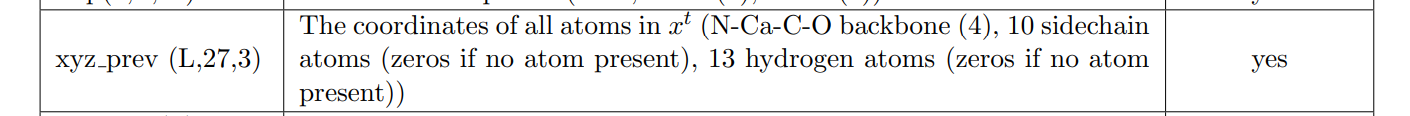
* feel free to print each key-values and check the dimension of each feature
* this func would generate features of target pdb
* It also contains several attibutes **H**, **L**, but they're empty here

# Antibody preparation
* Firstly, pass the framework features from the framework pdb, then update the **pos** variable.
* Check the **pose.H** and **pose.L** to ensure features are loaded after runing the func.
* The loop masks of each chain determin residue positions of the loops
* Warnings: The antibody-finetuned version of RFdiffusion in RFantibody requires an HLT-remarked framework structure as input. We provide a script to perform this conversion that can be run as follows:
    * python /home/scripts/util/chothia_to_HLT.py -inpdb mychothia.pdb -outpdb myHLT.pdb

In [85]:
framework_pdb = os.path.join(working_dir, "scripts/examples/example_inputs/hu-4D5-8_Fv.pdb")
pose.framework_from_HLT(framework_pdb)

pose.H.loop_masks['H3'] # the length of ref CDRH3 is 6

print(pose.length())
print(pose.binder_len())
print(pose.L.seq)

474
223
[ 3  9  5 12 16  5 15 14 15 15 10 15  0 15 19  7  3  1 19 16  9 16  4  1
  0 15  5  3 19  2 16  0 19  0 17 18  5  5 11 14  7 11  0 14 11 10 10  9
 18 15  0 15 13 10 18 15  7 19 14 15  1 13 15  7 15  1 15  7 16  3 13 16
 10 16  9 15 15 10  5 14  6  3 13  0 16 18 18  4  5  5  8 18 16 16 14 14
 16 13  7  5  7 16 11 19  6  9 11]


* Now we've already loaded the target structure and a scFv framework. What we're going to do next is determine the length of your CDR regions. Since RFantibody accepts variable CDR length, we can sample the CDR length from the pre-specified parameter **--antibody.design_loops**
* If you don't offer this parameter, the CDR length remains unchanged.

In [88]:
design_loops_list = ['H1:7', 'H2:6', 'H3:7-13', 'L1:8-13', 'L2:7', 'L3:9-11']

# we sample new CDRH3 from length 7-13
pose.adjust_loop_lengths(design_loops_list) 

# check the mask yourself, the number of mask should inside [8, 13]
pose.H.loop_masks['H3']

print(pose.length())
print(pose.binder_len())
print(pose.L.seq)

loop_mask = pose.parse_design_mask(design_loops_list)

478
227
[ 3  9  5 12 16  5 15 14 15 15 10 15  0 15 19  7  3  1 19 16  9 16  4 21
  0 15  5  3 19  2 16  0 19  0 17 18  5  5 11 14  7 11  0 14 11 10 10  9
 18 15  0 15 13 10 18 15  7 19 14 15  1 13 15  7 15  1 15  7 16  3 13 16
 10 16  9 15 15 10  5 14  6  3 13  0 16 18 18  4 21  5  5  8 18 16 16 14
 14 16 13  7  5  7 16 11 19  6  9 11]


# hotspots
* Remember there's another parameter from the command line **ppi.hotspot_res=[T305,T456]**. We can specify the target region where the binder dock.
* Hotspot residues need to be provided in pdb-indexed form. E.g. A100,A103

In [90]:
hotspots = pose.parse_hotspots(["T305","T456"])
hotspots

ic| f'Using {res} as a hotspot': "Using ['T' '305'] as a hotspot"
ic| f'Using {res} as a hotspot': "Using ['T' '456'] as a hotspot"


tensor([False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, 

Now the diffusion inputs are parepared, check the features below

In [91]:
diff_inputs = pose.to_diffusion_inputs()
diff_inputs

{'xyz_true': tensor([[[   5.3180,  151.8870,    1.1350],
          [   6.3720,  151.6040,    2.1530],
          [   7.5900,  150.9780,    1.4670],
          ...,
          [   0.0000,    0.0000,    0.0000],
          [   0.0000,    0.0000,    0.0000],
          [   0.0000,    0.0000,    0.0000]],
 
         [[   8.7800,  151.3660,    1.9010],
          [  10.0260,  150.6100,    1.6340],
          [   9.8650,  149.2100,    2.2370],
          ...,
          [   0.0000,    0.0000,    0.0000],
          [   0.0000,    0.0000,    0.0000],
          [   0.0000,    0.0000,    0.0000]],
 
         [[  10.3830,  148.1900,    1.5330],
          [  10.2660,  146.7580,    1.8960],
          [  11.4270,  145.9770,    1.2520],
          ...,
          [   0.0000,    0.0000,    0.0000],
          [   0.0000,    0.0000,    0.0000],
          [   0.0000,    0.0000,    0.0000]],
 
         ...,
 
         [[-110.3090,  152.3030,  277.6890],
          [-110.3960,  151.3990,  276.5700],
          [-110.59

* Next we are going to diffuse the coordinates including protein translations, rotations and chi angles 

In [95]:
from rfantibody.rfdiffusion.diffusion import Diffuser
import numpy as np
import torch

conf_diffuser = {'T': 200, 'b_0': 0.01, 'b_T': 0.07, 
                 'schedule_type': 'linear', 'so3_type': 'igso3', 
                 'aa_decode_steps': 0, 'chi_type': 'interp', 
                 'crd_scale': 0.25, 'schedule_kwargs': {}, 
                 'partial_T': None, 'so3_schedule_type': 'linear', 
                 'min_b': 1.5, 'max_b': 2.5, 'min_sigma': 0.02, 'max_sigma': 1.5,
                }

diffuser = Diffuser(**conf_diffuser)

#'preprocess': {'sidechain_input': False,
#                  'motif_sidechain_input': False,},

t_list = np.arange(1, 201)
diffusion_mask = torch.ones((pose.length())).bool()

# T_schene = "'single_T_correct_selfcond"
diffusion_mask[:pose.binder_len()] = False

fa_stack, _, _ = diffuser.diffuse_pose(
            diff_inputs.xyz_true,
            diff_inputs.seq_true,
            diff_inputs.atom_mask,
            diffusion_mask=diffusion_mask.squeeze(),
            t_list=t_list,
            diffuse_sidechains=False,
            include_motif_sidechains=False)

Successful diffuser __init__


In [139]:
# we're going to dive into the diffuse process.
#  Given full atom xyz, sequence and atom mask, diffuse the protein 
#  translations, rotations, and chi angles
#  this part of code is the implementation of function diffuse_pose above

# in this case, we don't implement torsion angle diffusion, so 2 diffusion process are activated

from rfantibody.rfdiffusion.util_module import ComputeAllAtomCoords
from rfantibody.rfdiffusion.diffusion import EuclideanDiffuser

get_allatom = ComputeAllAtomCoords()
L = len(diff_inputs.xyz_true)

# first of all, we need to bring the atoms to origin and scale them， bb atoms only
xyz = diff_inputs.xyz_true
nan_mask = ~torch.isnan(xyz.squeeze()[:, :3]).any(dim=-1).any(dim=-1)

assert torch.sum(~nan_mask) == 0

motif_com = xyz[diffusion_mask.squeeze(),1,:].mean(dim=0)

xyz = xyz[nan_mask] - motif_com # centuring
xyz_true = xyz.clone()

xyz *= conf_diffuser.get("crd_scale") # scale

# translation diffusion
eucl_diffuser = EuclideanDiffuser(conf_diffuser['T'],
                                  conf_diffuser['b_0'], 
                                  conf_diffuser['b_T'],
                                  schedule_type=conf_diffuser['schedule_type'],
                                  **conf_diffuser['schedule_kwargs'])

diffused_T, deltas = eucl_diffuser.diffuse_translations(xyz[:, :3, :].clone(), diffusion_mask=diffusion_mask.squeeze())

diffused_T /= conf_diffuser.get("crd_scale")
deltas     /= conf_diffuser.get("crd_scale")

* Let's check the diffuion process of transltion in detail

```python
def apply_kernel(self, x, t, diffusion_mask=None, var_scale=1):
    
    # Applies a noising kernel to the points in x 

    # Parameters:
    #     x (torch.tensor, required): (N,3,3) set of backbone coordinates 
    #     t (int, required): Which timestep
    #     var_scale (float, optional): scale for noise 
    
    t_idx = t - 1  # bring from 1-indexed to 0-indexed

    assert len(x.shape) == 3
    L, _, _ = x.shape 

    # c-alpha crds 
    ca_xyz = x[:, 1, :]
    b_t = self.beta_schedule[t_idx]    

    # get the noise at timestep t
    mean = torch.sqrt(1 - b_t) * ca_xyz
    var = torch.ones(L, 3) * b_t * var_scale

    sampled_crds = torch.normal(mean, torch.sqrt(var)) 
    delta = sampled_crds - ca_xyz  

    if diffusion_mask is not None:
        delta[diffusion_mask, ...] = 0

    out_crds = x + delta[:, None, :]

    return out_crds, delta
```

it's a standard DDPM diffsion process, the data is corrpted each step as follows:
$$
q(\mathbf{x}_{1:T} | \mathbf{x}_0) := \prod_{t=1}^T q(\mathbf{x}_t | \mathbf{x}_{t-1}), \quad q(\mathbf{x}_t | \mathbf{x}_{t-1}) := \mathcal{N}(\mathbf{x}_t; \sqrt{1 - \beta_t} \, \mathbf{x}_{t-1}, \beta_t \mathbf{I})
$$

from time $\mathbf{x}_{t-1}$ to $\mathbf{x}_t$, the data is corrupted by adding gaussian noise, the noise is controlled by the noise schedule which shown in the **apply_kernel**, the noise is sampled from a gussian distributin with mean = $\sqrt{1 - \beta_t} * \mathbf{x}_{t-1}$ and variance = $\beta{t} \mathbf{I}$, so when t is getting bigger, the more noise will be added to the data.



In [146]:
# frame diffusion
from rfantibody.rfdiffusion.diffusion import IGSO3

so3_diffuser =  IGSO3(
                T=conf_diffuser['T'],
                min_sigma=conf_diffuser['min_sigma'],
                max_sigma=conf_diffuser['max_sigma'],
                schedule=conf_diffuser['so3_schedule_type'],
                min_b=conf_diffuser['min_b'],
                max_b=conf_diffuser['max_b'],
                cache_dir='.',
                L=2000)

diffused_frame_crds, diffused_frames = so3_diffuser.diffuse_frames(xyz[:,:3,:].clone(), 
                                                                   diffusion_mask=diffusion_mask.squeeze().numpy(),
                                                                   t_list=None)
diffused_frame_crds /= conf_diffuser['crd_scale']

Let's dive into the diffusion process of rotations!
* First of all, we need to construct the local frame for each residue based on its backbone atoms (N, CA, C). This is the mplementation of Gram-Schmidt algorithm.
* Gram-Schimidt \
 $v1 = C- C_{a}$ \
 $v2 = N-C_{a}$ \
 $e1=v1/||v1||$ \
 $u2=v2-proj(v2, e1)$ \
 $e2=u2/||u2||$ \
 $e3=e1 * e2$ \
 $R=[e1, e2, e3]$

e1, e2, e3 are the orthonormal basis vectoors and R is the rotation matrix.

* Then random rotation vectors of T steps will be sampled from pre-calculated CDF using inverse CDF sampling. After that, sampled rotation matrix will be generated based on the rot vec. The perturbed rot matrix is obtained by $R_sampled * rot_matrix$.
* Finally, we will get the perturbed coordinates by multiplying the perturbed rotation matrix.

**If you want t learn more about geometry knowledge, plz go to this [link](https://github.com/kilianmandon/alphafold-decoded/blob/main/tutorials/geometry/geometry.ipynb).**

In [167]:
# then combine the rotations and translations of backbone atoms to get the diffused coordinates

cum_delta = deltas.cumsum(dim=1)
diffused_BB = (torch.asarray(diffused_frame_crds) + cum_delta.unsqueeze(-2)).transpose(1, 0)


In all, the **fa_stack (diffused_BB above)** represent the diffused coordinates now 

In [171]:
x_T = torch.clone(fa_stack[-1].squeeze()[:, :14])

So now we've got the diffused coordinates, another input is the input sequences. we should mask the CDR regions.

In [183]:
seq_T = torch.nn.functional.one_hot(diff_inputs.seq_true, num_classes=22).float()

#mask_seq = torch.clone()
seq_T[~loop_mask, :20] = 0
seq_T[~loop_mask, 21] = 1


Now we have the diffused coordinates **x_T** and masked sequences **seq_T**.

# Summary

In this notebook, we've covered the **data preparation** and **forward diffusion process** for protein backbone coordinates (`crds`). You've learned how to:
- Load structural data (e.g., PDB files),
- Apply timestep-dependent noise to coordinates using a diffusion kernel.

In upcoming tutorials, we’ll explore how the **denoising network** learns to reverse this process and generate novel protein structures.

We hope this notebook has been helpful! See you in the next session!